So, we left [the previous notebook](https://github.com/sayakpaul/ML-Bootcamp-Launchpad/blob/master/02_1_Data_Preparation.ipynb) with a question - "could we optimize the data processing time?" This is super important to investigate for the following reasons:
- We are using a GPU for training our model. But could we use it for processing the data chunks as well? Basically, while the model is training on batches of data there's a high chance that it can remain idle if the training data is available to it (and it can happen). 
- If we can optimize the data processing time, it will definitely result in faster training time as well because the model won't have to wait for the data to come to it. 
- This gives us an opportunity to mximize the resource utilization as well. Because there could be situations where the GPU/CPU is not being utilized fully. So while the model is training, in the background we could run some threads to fetch the next batch of data.

Let's start the investigation! 

`tf.data` would be a good start here since it offers you many legacy functions like `batch`, `prefetch`, `map`, `repeat` which can be used for drastically reducing the data processing time.

We would first start by converting our images to [TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord) which are nothing but a form of protobuffers. This will allow us to load our data even faster since TFRecords are light-weight and play out very well with `tf.data`. 

**Acknowledgement**: [Martin Görner](https://twitter.com/martin_gorner) & his [amazing tutorial notebook](https://nbviewer.jupyter.org/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/keras_flowers_gputputpupod_tf2.1.ipynb).

In [28]:
# imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pathlib
import time
import re
import os

In [2]:
# don't change this
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

We will use the following function for loading our images from disk and also their labels.

In [3]:
# function to read the image from the path,
# parse its labels, cast the pixel values to float,
# and resize the image
def parse_image(filename):
    parts = tf.strings.split(filename, '/')
    label = parts[-2]
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return (image, label)

`map` helps us in parallelizing things pretty easily. 

In [4]:
def prep_init_dataset(set_dir):
    dataset = tf.data.Dataset.list_files(str(pathlib.Path(set_dir)/'*/*'), seed=666)
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [5]:
train_dataset = prep_init_dataset("train")
test_dataset = prep_init_dataset("test")

`tf.data.experimental.AUTOTUNE` helps to determine the level parallelism to use _dynamically_. 

TFRecords need data in certain formats. So, for images they need to be serialized as byte-strings and the labels would be integers (non one-hot encoded ones).

In [6]:
# Images are byte-strings
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

# Classes would be integers
def _int_feature(list_of_ints): 
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

We should now be able to utilize the above functions to create TFRecords. 

In [7]:
# function that prepares a record for the tfrecord file
# a record contains the image and its label
def to_tfrecord(img_bytes, label):  
    class_num = np.argmax(np.array(CLASSES)==label) 
    # print(class_num)
    feature = {
      "image": _bytestring_feature([img_bytes]), 
      "class": _int_feature([class_num]),             
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [8]:
# we need to convert the image to byte strings
# https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg
def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

In [9]:
# recompress the images
def recompress_dataset(dataset):
    dataset = dataset.map(recompress_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32) # more on this later
    return dataset

In [10]:
train_dataset = recompress_dataset(train_dataset)
test_dataset = recompress_dataset(test_dataset)

Let's go.

In [11]:
# prepare tfrecords
def prepare_tfrecords(dataset, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for shard, (image, label) in enumerate(tqdm(dataset)):
        shard_size = image.numpy().shape[0]
        filename = output_dir + "/flowers-" + "{:02d}-{}.tfrec".format(shard, shard_size)

        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(shard_size):
                # print(label.numpy()[i])
                example = to_tfrecord(image.numpy()[i],label.numpy()[i])
                out_file.write(example.SerializeToString())
            print("Wrote file {} containing {} records".format(filename, shard_size))

In [12]:
prepare_tfrecords(train_dataset, "train_tfr")

2it [00:00,  4.44it/s]

Wrote file train_tfr/flowers-00-32.tfrec containing 32 records
Wrote file train_tfr/flowers-01-32.tfrec containing 32 records


4it [00:00,  5.88it/s]

Wrote file train_tfr/flowers-02-32.tfrec containing 32 records
Wrote file train_tfr/flowers-03-32.tfrec containing 32 records


6it [00:00,  6.73it/s]

Wrote file train_tfr/flowers-04-32.tfrec containing 32 records
Wrote file train_tfr/flowers-05-32.tfrec containing 32 records


8it [00:01,  6.37it/s]

Wrote file train_tfr/flowers-06-32.tfrec containing 32 records
Wrote file train_tfr/flowers-07-32.tfrec containing 32 records


10it [00:01,  5.58it/s]

Wrote file train_tfr/flowers-08-32.tfrec containing 32 records
Wrote file train_tfr/flowers-09-32.tfrec containing 32 records


11it [00:01,  5.55it/s]

Wrote file train_tfr/flowers-10-32.tfrec containing 32 records


13it [00:02,  5.29it/s]

Wrote file train_tfr/flowers-11-32.tfrec containing 32 records
Wrote file train_tfr/flowers-12-32.tfrec containing 32 records


14it [00:02,  5.13it/s]

Wrote file train_tfr/flowers-13-32.tfrec containing 32 records


15it [00:02,  4.95it/s]

Wrote file train_tfr/flowers-14-32.tfrec containing 32 records


17it [00:03,  5.03it/s]

Wrote file train_tfr/flowers-15-32.tfrec containing 32 records
Wrote file train_tfr/flowers-16-32.tfrec containing 32 records


19it [00:03,  5.00it/s]

Wrote file train_tfr/flowers-17-32.tfrec containing 32 records
Wrote file train_tfr/flowers-18-32.tfrec containing 32 records


20it [00:03,  5.01it/s]

Wrote file train_tfr/flowers-19-32.tfrec containing 32 records


22it [00:03,  5.24it/s]

Wrote file train_tfr/flowers-20-32.tfrec containing 32 records
Wrote file train_tfr/flowers-21-32.tfrec containing 32 records


24it [00:04,  5.00it/s]

Wrote file train_tfr/flowers-22-32.tfrec containing 32 records
Wrote file train_tfr/flowers-23-32.tfrec containing 32 records


26it [00:04,  5.01it/s]

Wrote file train_tfr/flowers-24-32.tfrec containing 32 records
Wrote file train_tfr/flowers-25-32.tfrec containing 32 records


28it [00:05,  5.13it/s]

Wrote file train_tfr/flowers-26-32.tfrec containing 32 records
Wrote file train_tfr/flowers-27-32.tfrec containing 32 records


30it [00:05,  5.14it/s]

Wrote file train_tfr/flowers-28-32.tfrec containing 32 records
Wrote file train_tfr/flowers-29-32.tfrec containing 32 records


31it [00:05,  5.18it/s]

Wrote file train_tfr/flowers-30-32.tfrec containing 32 records


32it [00:06,  4.99it/s]

Wrote file train_tfr/flowers-31-32.tfrec containing 32 records


34it [00:06,  4.88it/s]

Wrote file train_tfr/flowers-32-32.tfrec containing 32 records
Wrote file train_tfr/flowers-33-32.tfrec containing 32 records


36it [00:06,  4.90it/s]

Wrote file train_tfr/flowers-34-32.tfrec containing 32 records
Wrote file train_tfr/flowers-35-32.tfrec containing 32 records


37it [00:07,  4.94it/s]

Wrote file train_tfr/flowers-36-32.tfrec containing 32 records


38it [00:07,  4.68it/s]

Wrote file train_tfr/flowers-37-32.tfrec containing 32 records


40it [00:07,  4.81it/s]

Wrote file train_tfr/flowers-38-32.tfrec containing 32 records
Wrote file train_tfr/flowers-39-32.tfrec containing 32 records


42it [00:08,  4.90it/s]

Wrote file train_tfr/flowers-40-32.tfrec containing 32 records
Wrote file train_tfr/flowers-41-32.tfrec containing 32 records


43it [00:08,  4.81it/s]

Wrote file train_tfr/flowers-42-32.tfrec containing 32 records


44it [00:08,  4.73it/s]

Wrote file train_tfr/flowers-43-32.tfrec containing 32 records


45it [00:08,  4.69it/s]

Wrote file train_tfr/flowers-44-32.tfrec containing 32 records


47it [00:09,  4.98it/s]

Wrote file train_tfr/flowers-45-32.tfrec containing 32 records
Wrote file train_tfr/flowers-46-32.tfrec containing 32 records


49it [00:09,  4.89it/s]

Wrote file train_tfr/flowers-47-32.tfrec containing 32 records
Wrote file train_tfr/flowers-48-32.tfrec containing 32 records


50it [00:09,  4.95it/s]

Wrote file train_tfr/flowers-49-32.tfrec containing 32 records


52it [00:10,  4.86it/s]

Wrote file train_tfr/flowers-50-32.tfrec containing 32 records
Wrote file train_tfr/flowers-51-32.tfrec containing 32 records


53it [00:10,  4.79it/s]

Wrote file train_tfr/flowers-52-32.tfrec containing 32 records
Wrote file train_tfr/flowers-53-32.tfrec containing 32 records


56it [00:11,  4.91it/s]

Wrote file train_tfr/flowers-54-32.tfrec containing 32 records
Wrote file train_tfr/flowers-55-32.tfrec containing 32 records


58it [00:11,  4.92it/s]

Wrote file train_tfr/flowers-56-32.tfrec containing 32 records
Wrote file train_tfr/flowers-57-32.tfrec containing 32 records


60it [00:11,  4.98it/s]

Wrote file train_tfr/flowers-58-32.tfrec containing 32 records
Wrote file train_tfr/flowers-59-32.tfrec containing 32 records


61it [00:12,  4.85it/s]

Wrote file train_tfr/flowers-60-32.tfrec containing 32 records


63it [00:12,  4.90it/s]

Wrote file train_tfr/flowers-61-32.tfrec containing 32 records
Wrote file train_tfr/flowers-62-32.tfrec containing 32 records


64it [00:12,  4.66it/s]

Wrote file train_tfr/flowers-63-32.tfrec containing 32 records


65it [00:12,  4.71it/s]

Wrote file train_tfr/flowers-64-32.tfrec containing 32 records


66it [00:13,  4.64it/s]

Wrote file train_tfr/flowers-65-32.tfrec containing 32 records


68it [00:13,  5.15it/s]

Wrote file train_tfr/flowers-66-32.tfrec containing 32 records
Wrote file train_tfr/flowers-67-32.tfrec containing 32 records


69it [00:13,  4.96it/s]

Wrote file train_tfr/flowers-68-32.tfrec containing 32 records


71it [00:14,  4.89it/s]

Wrote file train_tfr/flowers-69-32.tfrec containing 32 records
Wrote file train_tfr/flowers-70-32.tfrec containing 32 records


72it [00:14,  4.74it/s]

Wrote file train_tfr/flowers-71-32.tfrec containing 32 records


73it [00:14,  4.71it/s]

Wrote file train_tfr/flowers-72-32.tfrec containing 32 records


74it [00:14,  4.70it/s]

Wrote file train_tfr/flowers-73-32.tfrec containing 32 records


76it [00:15,  4.93it/s]

Wrote file train_tfr/flowers-74-32.tfrec containing 32 records
Wrote file train_tfr/flowers-75-32.tfrec containing 32 records


77it [00:15,  4.84it/s]

Wrote file train_tfr/flowers-76-32.tfrec containing 32 records


78it [00:15,  4.77it/s]

Wrote file train_tfr/flowers-77-32.tfrec containing 32 records


79it [00:15,  4.81it/s]

Wrote file train_tfr/flowers-78-32.tfrec containing 32 records


80it [00:16,  4.81it/s]

Wrote file train_tfr/flowers-79-32.tfrec containing 32 records


82it [00:16,  4.98it/s]

Wrote file train_tfr/flowers-80-32.tfrec containing 32 records
Wrote file train_tfr/flowers-81-32.tfrec containing 32 records


83it [00:16,  4.96it/s]

Wrote file train_tfr/flowers-82-32.tfrec containing 32 records


84it [00:16,  4.93it/s]

Wrote file train_tfr/flowers-83-32.tfrec containing 32 records


86it [00:17,  5.12it/s]

Wrote file train_tfr/flowers-84-32.tfrec containing 32 records
Wrote file train_tfr/flowers-85-32.tfrec containing 32 records


88it [00:17,  4.94it/s]

Wrote file train_tfr/flowers-86-32.tfrec containing 32 records
Wrote file train_tfr/flowers-87-32.tfrec containing 32 records


90it [00:18,  4.77it/s]

Wrote file train_tfr/flowers-88-32.tfrec containing 32 records
Wrote file train_tfr/flowers-89-32.tfrec containing 32 records


91it [00:18,  4.94it/s]

Wrote file train_tfr/flowers-90-32.tfrec containing 32 records


93it [00:18,  5.14it/s]

Wrote file train_tfr/flowers-91-32.tfrec containing 32 records
Wrote file train_tfr/flowers-92-32.tfrec containing 32 records


94it [00:18,  4.96it/s]

Wrote file train_tfr/flowers-93-32.tfrec containing 32 records


96it [00:19,  5.07it/s]

Wrote file train_tfr/flowers-94-32.tfrec containing 32 records
Wrote file train_tfr/flowers-95-32.tfrec containing 32 records


98it [00:19,  5.01it/s]

Wrote file train_tfr/flowers-96-32.tfrec containing 32 records
Wrote file train_tfr/flowers-97-16.tfrec containing 16 records


In [13]:
prepare_tfrecords(test_dataset, "test_tfr")

2it [00:00,  6.51it/s]

Wrote file test_tfr/flowers-00-32.tfrec containing 32 records
Wrote file test_tfr/flowers-01-32.tfrec containing 32 records


5it [00:00,  7.92it/s]

Wrote file test_tfr/flowers-02-32.tfrec containing 32 records
Wrote file test_tfr/flowers-03-32.tfrec containing 32 records
Wrote file test_tfr/flowers-04-32.tfrec containing 32 records


9it [00:00, 10.22it/s]

Wrote file test_tfr/flowers-05-32.tfrec containing 32 records
Wrote file test_tfr/flowers-06-32.tfrec containing 32 records
Wrote file test_tfr/flowers-07-32.tfrec containing 32 records
Wrote file test_tfr/flowers-08-32.tfrec containing 32 records


11it [00:00, 11.41it/s]

Wrote file test_tfr/flowers-09-32.tfrec containing 32 records
Wrote file test_tfr/flowers-10-32.tfrec containing 32 records
Wrote file test_tfr/flowers-11-32.tfrec containing 32 records


18it [00:01, 13.37it/s]

Wrote file test_tfr/flowers-12-32.tfrec containing 32 records
Wrote file test_tfr/flowers-13-32.tfrec containing 32 records
Wrote file test_tfr/flowers-14-32.tfrec containing 32 records
Wrote file test_tfr/flowers-15-32.tfrec containing 32 records
Wrote file test_tfr/flowers-16-32.tfrec containing 32 records
Wrote file test_tfr/flowers-17-6.tfrec containing 6 records


We can verify if total number of images from each of the sets got covered appropriately. I will leave that part to you. 

Sorry about the filthy logs! `dataset = dataset.batch(32)` this step is needed to ensure the number of records going in a single TFRecord file. 

Now that we have the TFRecords ready with us, let's parse them and actually build a data input pipeline. Don't worry, we will perform the speed-test as well! 

In the following set of functions, we will be doing the following:
- Read the TFRecords
- Decode them into images
- Resize the images
- Augment the images
- Prepare `tf.data.Dataset` from the images
- Normal data processing utilities
    - Batch the dataset
    - Shuffle if the data is training data
    - Prefetch the data so that is ready as soon as an epoch ends

In [14]:
# function to read the TFRecords, segregate the images and labels
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [224, 224, 3]) 
    class_label = tf.cast(example['class'], tf.int32)
    
    return (image, class_label)

In [15]:
# a bit of data augmentation
def data_augment(image, class_label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return (image, class_label)

In [16]:
# load the TFRecords and create tf.data.Dataset
def load_dataset(filenames):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [17]:
# we need this to derive the steps for generator
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [18]:
# batch, shuffle, and repeat the dataset and pre-fetch it
# well before the current epoch ends
def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat()
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
    else:
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 
    return (dataset, n//batch_size)

In [19]:
# let's load up the tfrecord filenames
tfrecord_pattern = "train_tfr/*.tfrec"
train_filenames = tf.io.gfile.glob(tfrecord_pattern)
train_filenames[:10]

['train_tfr/flowers-11-32.tfrec',
 'train_tfr/flowers-23-32.tfrec',
 'train_tfr/flowers-70-32.tfrec',
 'train_tfr/flowers-25-32.tfrec',
 'train_tfr/flowers-67-32.tfrec',
 'train_tfr/flowers-43-32.tfrec',
 'train_tfr/flowers-84-32.tfrec',
 'train_tfr/flowers-77-32.tfrec',
 'train_tfr/flowers-58-32.tfrec',
 'train_tfr/flowers-66-32.tfrec']

In [20]:
tfr_pattern_test = "test_tfr/*.tfrec"
test_filenames = tf.io.gfile.glob(tfr_pattern_test)
test_filenames[:5]

['test_tfr/flowers-11-32.tfrec',
 'test_tfr/flowers-04-32.tfrec',
 'test_tfr/flowers-00-32.tfrec',
 'test_tfr/flowers-07-32.tfrec',
 'test_tfr/flowers-16-32.tfrec']

Always a good idea to visually inspect your datasets to make sure things would work!

In [24]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
        
    return (numpy_images, numpy_labels)

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[labels[i]]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;

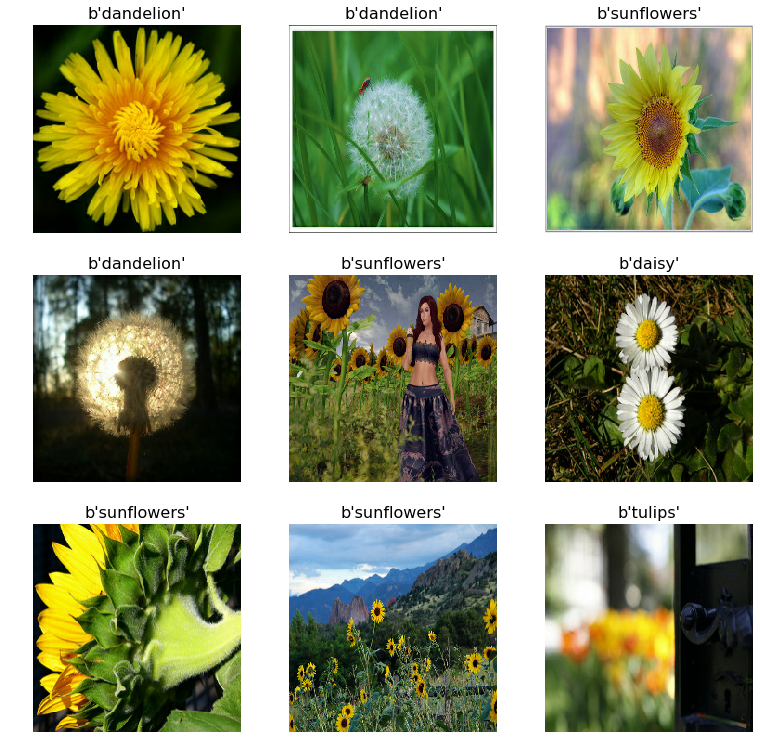

In [26]:
display_9_images_from_dataset(load_dataset(train_filenames))

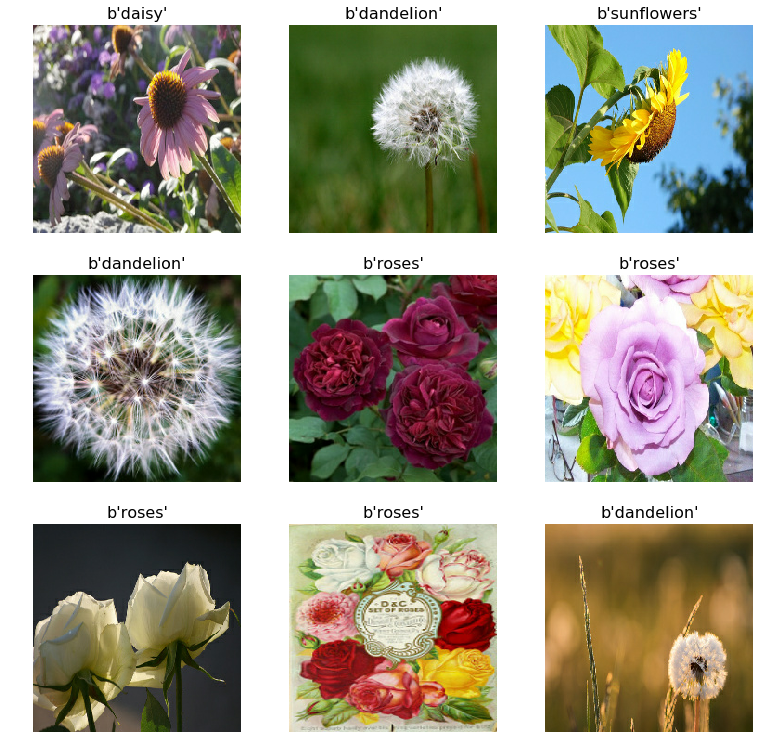

In [27]:
display_9_images_from_dataset(load_dataset(test_filenames))

Looks like everything's well enough! Let's now measure the time. 

In [29]:
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(32*steps/duration))

In [31]:
training_dataset, _ = batch_dataset(train_filenames, 32, True)
timeit(training_dataset)

....................................................................................................
1000 batches: 22.647370100021362 s
1412.96759 Images/s


The speed up is quite evident :) This can be further sped up by using `tf.function` decorator.